In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from BabelViscoFDTD.H5pySimple import ReadFromH5py,SaveToH5py
from BabelViscoFDTD.PropagationModel import PropagationModel
from scipy import ndimage
from skimage.draw import circle_perimeter,disk
from skimage.transform import rotate
PModel=PropagationModel()


StaggeredFDTD_3D_CUDA loaded
StaggeredFDTD_3D_OPENCL NOT loaded
StaggeredFDTD_3D_METAL NOT loaded


### Preamble
Please consult first the examples in the `1 - Flat source homgenous medium.ipynb` and `2 - Control of directivity .ipynb` notebooks for the basics how to run a simulation and understanding of how to prepare correctly the directivity of a source


In this example we apply the previous concepts to model a focused source

# 1 - Focused source


In [2]:
Frequency = 350e3  # Hz
MediumSOS = 1500 # m/s - water
MediumDensity=1000 # kg/m3

ShortestWavelength =MediumSOS / Frequency
SpatialStep =ShortestWavelength / 8.0 # A minimal step of 6 is recommnded

DimDomain =  np.array([0.05,0.05,0.08])  # in m, x,y,z

FactorConvPtoU=MediumSOS*MediumDensity

SourceAmp=60e3/FactorConvPtoU # Pressure pf 60 kPa at the Surfacee

TxRadius = 0.04 # m, 
TxDiameter=0.04
PMLThickness = 12 # grid points for perect matching layer, HIGHLY RECOMMENDED DO NOT CHANGE THIS SIZE 
ReflectionLimit= 1.0000e-05 #reflection parameter for PML, IGHLY RECOMMENDED DO NOT CHANGE THIS VALUE

N1=int(np.ceil(DimDomain[0]/SpatialStep)+2*PMLThickness)
N2=int(np.ceil(DimDomain[1]/SpatialStep)+2*PMLThickness)
N3=int(np.ceil(DimDomain[2]/SpatialStep)+2*PMLThickness)
print('Domain size',N1,N2,N3)
TimeSimulation=np.sqrt(DimDomain[0]**2+DimDomain[1]**2+DimDomain[2]**2)/MediumSOS #time to cross one corner to another
TemporalStep=1e-7 # if this step is too coarse a warning will be generated (but simulation will continue,) 

MaterialMap=np.zeros((N1,N2,N3),np.uint32) # note the 32 bit size
MaterialList=np.zeros((1,5)) # one material in this examples
MaterialList[0,0]=MediumDensity # water density
MaterialList[0,1]=MediumSOS # water SoS
#all other parameters are set to 0 


Domain size 118 118 174


We apply the concepts on directivity to model a spherical cap for a focusing source. Below there is a function that uses scikit-image to prepare the mask of a spherical cap and how we can prepare correctly the directivity of each entry in the source mask.

C:\Users\samme\.edm\envs\MORPHEUS36\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


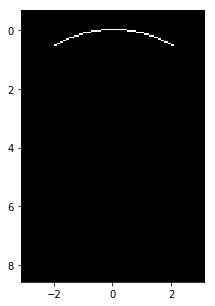

In [3]:

def MakeFocusingSource(N1,N2,N3,SpatialStep,TxRadius,TxDiameter,Angle):
    #simple defintion of a focusing source centred in the domain, 
    #please note this is not a bullet-proof solution as it may not work for all cases
    XDim=np.arange(N1)*SpatialStep
    YDim=np.arange(N2)*SpatialStep
    ZDim=np.arange(N3)*SpatialStep
    XDim-=XDim[int(N1/2)]
    YDim-=YDim[int(N2/2)]
    ZDim-=ZDim[int(N3/2)]
    XX,YY,ZZ=np.meshgrid(YDim,XDim,ZDim)#note we have to invert this because how meshgrid works
    Depth=np.sqrt(TxRadius**2-(TxDiameter/2.0)**2)
    cX=int(N1/2)
    cZ=int(N3/2)
    
    MaskSource=np.zeros((N1,N2,N3),np.bool)
    FillMask=np.zeros((N1,N2,N3))
    
    for n,y in enumerate(YDim):
        if np.abs(y)<TxRadius:
            cDiam=int(np.ceil(TxRadius*np.sin(np.arccos(y/TxRadius))/SpatialStep))
            rr, cc = circle_perimeter(cX,cZ,cDiam,shape=(N1,N3))
            MaskSource[rr,n,cc]=np.True_
            rr,cc=disk((cX,cZ),cDiam+1,shape=(N1,N3))
            FillMask[rr,n,cc]=1
            
    
    FillMask[ZZ<=-Depth]=0.
    #instead of rotating the arc, we rotate the mask that will negate the perimeter to be turned off
    if Angle!=0.:
        for n in range(N2):
            FillMask[:,n,:]=rotate(FillMask[:,n,:],Angle,preserve_range=True)
        
    MaskSource[FillMask!=0]=False
        
    #since the sphere mask is 0-centred, the orientation vectors in each point is straighforward
    OxOyOz=np.vstack((-XX.flatten(),-YY.flatten(),-ZZ.flatten())).T
    #and we just normalize
    OxOyOz/=np.tile( np.linalg.norm(OxOyOz,axis=1).reshape(OxOyOz.shape[0],1),[1,3])
    Ox=OxOyOz[:,1].reshape(XX.shape) 
    Oy=OxOyOz[:,0].reshape(XX.shape)
    Oz=OxOyOz[:,2].reshape(XX.shape)
    Ox[MaskSource==False]=0
    Oy[MaskSource==False]=0
    Oz[MaskSource==False]=0
    return MaskSource.astype(np.uint32),Ox,Oy,Oz

SourceMap,Ox,Oy,Oz=MakeFocusingSource(N1,N2,N3,SpatialStep,TxRadius,TxDiameter,0)
XDim=(np.arange(N1)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
XDim-=XDim.mean()
ZDim=(np.arange(N3)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
plt.figure(figsize=(6,5))
plt.imshow(SourceMap[:,int(N2/2),:].T,cmap=plt.cm.gray,extent=[XDim.min(),XDim.max(),ZDim.max(),ZDim.min()]);


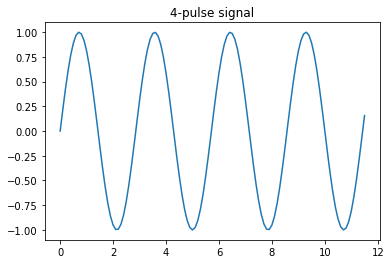

In [4]:
LengthSource=4.0/Frequency #we will use 4 pulses
TimeVectorSource=np.arange(0,LengthSource+TemporalStep,TemporalStep)

PulseSource = np.sin(2*np.pi*Frequency*TimeVectorSource)
plt.figure()
plt.plot(TimeVectorSource*1e6,PulseSource)
plt.title('4-pulse signal')

#note we need expressively to arrange the data in a 2D array
PulseSource=np.reshape(PulseSource,(1,len(TimeVectorSource))) 

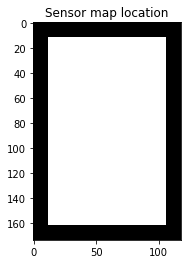

In [5]:
SensorMap=np.zeros((N1,N2,N3),np.uint32)

SensorMap[PMLThickness:-PMLThickness,int(N2/2),PMLThickness:-PMLThickness]=1

plt.figure()
plt.imshow(SensorMap[:,int(N2/2),:].T,cmap=plt.cm.gray)
plt.title('Sensor map location');

In [6]:
Sensor,LastMap,DictRMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         Ox*SourceAmp,
                                                         Oy*SourceAmp,
                                                         Oz*SourceAmp,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         NDelta=PMLThickness,
                                                         DT=TemporalStep,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=1,
                                                         USE_SINGLE=True,
                                                         SelRMSorPeak=2,
                                                         SelMapsRMSPeakList=['ALLV','Pressure'],
                                                         DefaultGPUDeviceName='SUPER',
                                                         TypeSource=1)

VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
VLongMat,VShearMat [1500.] [0.]
dt,VLongMat,VShearMat,TauLong,TauShear,TauSigma,VLongInput,VShearInput 1.749724795401213e-07 [1500.] [0.] [0.] [0.] [4.54728409e-07] [1500.] [0.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 1e-07 1.749724795401213e-07
Matrix size= 118 x 118 x 174 , spatial resolution = 0.000535714, time steps = 712, temporal step = 1e-07, total sonication length 7.11805e-05 
Performing Simulation wtih GPU CUDA
Running with new interface conditions
SizePML=1097377
SizePMLxp1=1117909
SizePMLyp1=1117909
SizePMLzp1=1111301
SizePMLxp1yp1zp1=1152776
 Staggered FDTD - compiled at Feb 12 2021 - 16:21:18
N1, N2,N3 , ZoneCount and DT= 118,118,174,1,1e-07
Number of sensors , timesteps for sensors and total maps= 14100, 357, 3
before cudaGetDeviceCount 
after cudaGetDeviceCount 
There is 1 device.
Found device [0:0]:
  Name: GeForce RT

### Ploting data

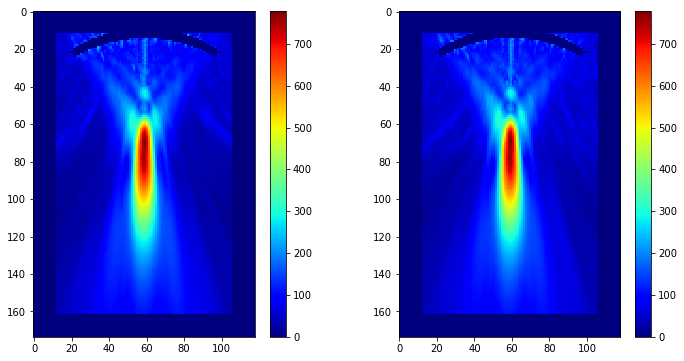

In [7]:
RMSValue=DictRMSValue['Pressure']
for a in range(3):
    for n in range(-2,3):
        RMSValue[np.roll(SourceMap>0,n,axis=a)]=0. #we turn off the values close the source 

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(RMSValue[:,int(N2/2),:].T/1e6,cmap=plt.cm.jet)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(RMSValue[int(N1/2),:,:].T/1e6,cmap=plt.cm.jet)
plt.colorbar();

We can see the focused field produced by the concave source

# Rotated focused transducer
The function declared above is ready to produce a rotated source in the $Y$-axis. We run a simulation with a source rotated 20 degrees.

In [9]:
DimDomain =  np.array([0.1,0.1,0.08])  # in m, x,y,z

TxRadius = 0.04 # m, 
TxDiameter=0.04
TxPlaneLocation = 0.01  # m , in XY plane at Z = 0.01 m

PMLThickness = 12 # grid points for perect matching layer, HIGHLY RECOMMENDED DO NOT CHANGE THIS SIZE 
ReflectionLimit= 1.0000e-05 #reflection parameter for PML, IGHLY RECOMMENDED DO NOT CHANGE THIS VALUE

N1=int(np.ceil(DimDomain[0]/SpatialStep)+2*PMLThickness)
N2=int(np.ceil(DimDomain[1]/SpatialStep)+2*PMLThickness)
N3=int(np.ceil(DimDomain[2]/SpatialStep)+2*PMLThickness)
print('Domain size',N1,N2,N3)
TimeSimulation=np.sqrt(DimDomain[0]**2+DimDomain[1]**2+DimDomain[2]**2)/MediumSOS #time to cross one corner to another
TemporalStep=1e-7 # if this step is too coarse a warning will be generated (but simulation will continue,) 

MaterialMap=np.zeros((N1,N2,N3),np.uint32) # note the 32 bit size
MaterialList=np.zeros((1,5)) # one material in this examples
MaterialList[0,0]=MediumDensity # water density
MaterialList[0,1]=MediumSOS # water SoS
#all other parameters are set to 0 


Domain size 211 211 174


(211, 211, 174) (211, 211, 174) (211, 211, 174) (211, 211, 174) (211, 211, 174)


/home/samies/.local/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


array([0.75293875, 0.75405798, 0.75504968, 0.75591233, 0.75664458,
       0.75724527, 0.75771347, 0.75804843, 0.75824962, 0.75831672])

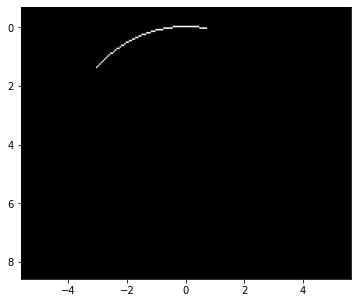

In [10]:
SourceMap,Ox,Oy,Oz=MakeFocusingSource(N1,N2,N3,SpatialStep,TxRadius,TxDiameter,-20) # here the -20
#SourceMap=np.roll(SourceMap,-10,axis=0)
print(SourceMap.shape,Ox.shape,Oy.shape,Oz.shape,MaterialMap.shape)

XDim=(np.arange(N1)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
XDim-=XDim.mean()
ZDim=(np.arange(N3)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
plt.figure(figsize=(6,5))
plt.imshow(SourceMap[:,int(N2/2),:].T,cmap=plt.cm.gray,extent=[XDim.min(),XDim.max(),ZDim.max(),ZDim.min()]);
Ox[SourceMap>0][0:10]

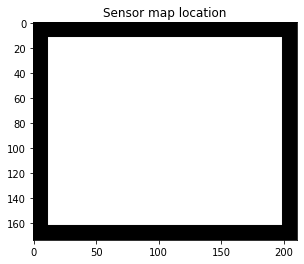

In [11]:
SensorMap=np.zeros((N1,N2,N3),np.uint32)

SensorMap[PMLThickness:-PMLThickness,int(N2/2),PMLThickness:-PMLThickness]=1

plt.figure()
plt.imshow(SensorMap[:,int(N2/2),:].T,cmap=plt.cm.gray)
plt.title('Sensor map location');

In [12]:
Sensor,LastMap,DictRMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         Ox,
                                                         Oy,
                                                         Oz,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         DT=TemporalStep,
                                                         COMPUTING_BACKEND=1,
                                                         USE_SINGLE=True,
                                                         SelMapsRMSPeakList=['ALLV'],
                                                         DefaultGPUDeviceName='SUPER',
                                                         TypeSource=1)

VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
VLongMat,VShearMat [1500.] [0.]
dt,VLongMat,VShearMat,TauLong,TauShear,TauSigma,VLongInput,VShearInput 1.749724795401213e-07 [1500.] [0.] [0.] [0.] [4.54728409e-07] [1500.] [0.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 1e-07 1.749724795401213e-07
Matrix size= 211 x 211 x 174 , spatial resolution = 0.000535714, time steps = 1084, temporal step = 1e-07, total sonication length 0.000108321 
Performing Simulation wtih GPU CUDA
Running with new interface conditions
SizePML=0
SizePMLxp1=0
SizePMLyp1=0
SizePMLzp1=0
SizePMLxp1yp1zp1=0
 Staggered FDTD - compiled at Jan  7 2021 - 19:31:14
N1, N2,N3 , ZoneCount and DT= 211,211,174,1e-07
Number of sensors , timesteps for sensors and total maps= 28050, 543, 3
before cudaGetDeviceCount 
after cudaGetDeviceCount 
There is 1 device.
Found device [0:0]:
  Name: GeForce RTX 2080 SUPER
  Compute capabili

### Ploting data

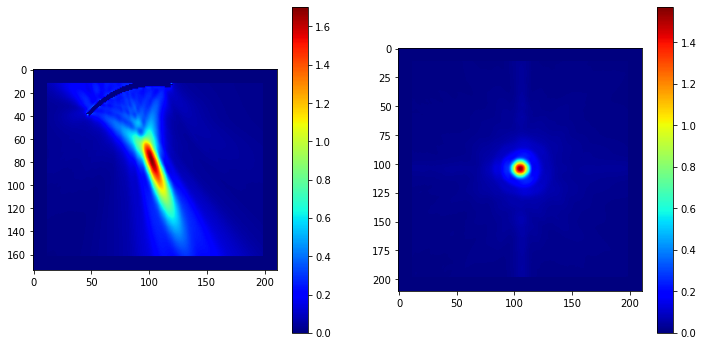

In [13]:
RMSValue=DictRMSValue['ALLV']
for n in range(-2,3):
    RMSValue[np.roll(SourceMap>0,n,axis=0)]=0. #we turn off the values close the source 
for n in range(-2,3):
    RMSValue[np.roll(SourceMap>0,n,axis=2)]=0. #we turn off the values close the source 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(RMSValue[:,int(N2/2),:].T,cmap=plt.cm.jet)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(RMSValue[:,:,int(N3/2)].T,cmap=plt.cm.jet)
plt.colorbar();

We can see the rotated focused field

# Source rotated 90 degrees 

As an interesting case to validate that the directivity of the source is correctly defined, we apply a 90 degrees rotation.

(211, 211, 174) (211, 211, 174) (211, 211, 174) (211, 211, 174) (211, 211, 174)


/home/samies/.local/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


array([0.98735506, 0.98864096, 0.98975948, 0.99070889, 0.99148771,
       0.99209474, 0.99252901, 0.99278985, 0.99287684, 0.99278985])

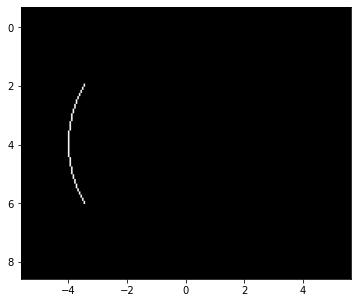

In [14]:
SourceMap,Ox,Oy,Oz=MakeFocusingSource(N1,N2,N3,SpatialStep,TxRadius,TxDiameter,-90)
#SourceMap=np.roll(SourceMap,-10,axis=0)
print(SourceMap.shape,Ox.shape,Oy.shape,Oz.shape,MaterialMap.shape)

XDim=(np.arange(N1)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
XDim-=XDim.mean()
ZDim=(np.arange(N3)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
plt.figure(figsize=(6,5))
plt.imshow(SourceMap[:,int(N2/2),:].T,cmap=plt.cm.gray,extent=[XDim.min(),XDim.max(),ZDim.max(),ZDim.min()]);
Ox[SourceMap>0][0:10]

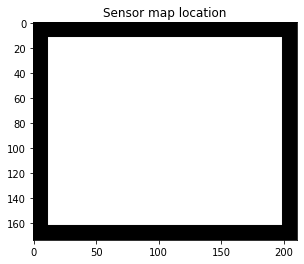

In [15]:
SensorMap=np.zeros((N1,N2,N3),np.uint32)

SensorMap[PMLThickness:-PMLThickness,int(N2/2),PMLThickness:-PMLThickness]=1

plt.figure()
plt.imshow(SensorMap[:,int(N2/2),:].T,cmap=plt.cm.gray)
plt.title('Sensor map location');

In [16]:
Sensor,LastMap,DictRMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         Ox,
                                                         Oy,
                                                         Oz,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         NDelta=PMLThickness,
                                                         DT=TemporalStep,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=1,
                                                         USE_SINGLE=True,
                                                         SelMapsRMSPeakList=['ALLV'],
                                                         DefaultGPUDeviceName='SUPER',
                                                         TypeSource=1)

VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
VLongMat,VShearMat [1500.] [0.]
dt,VLongMat,VShearMat,TauLong,TauShear,TauSigma,VLongInput,VShearInput 1.749724795401213e-07 [1500.] [0.] [0.] [0.] [4.54728409e-07] [1500.] [0.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 1e-07 1.749724795401213e-07
Matrix size= 211 x 211 x 174 , spatial resolution = 0.000535714, time steps = 1084, temporal step = 1e-07, total sonication length 0.000108321 
Performing Simulation wtih GPU CUDA
Running with new interface conditions
SizePML=0
SizePMLxp1=0
SizePMLyp1=0
SizePMLzp1=0
SizePMLxp1yp1zp1=0
 Staggered FDTD - compiled at Jan  7 2021 - 19:31:14
N1, N2,N3 , ZoneCount and DT= 211,211,174,1e-07
Number of sensors , timesteps for sensors and total maps= 28050, 543, 3
before cudaGetDeviceCount 
after cudaGetDeviceCount 
There is 1 device.
Found device [0:0]:
  Name: GeForce RTX 2080 SUPER
  Compute capabili

### Ploting data

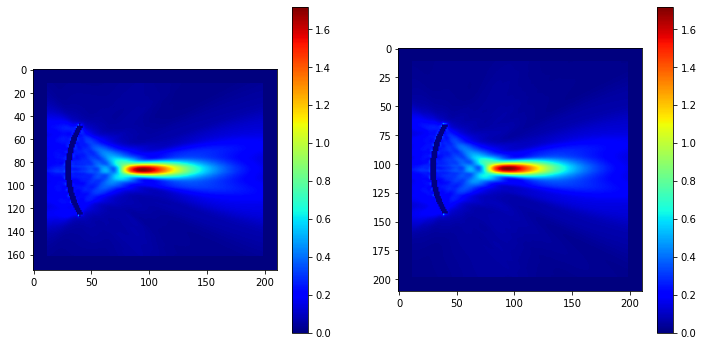

In [17]:
RMSValue=DictRMSValue['ALLV'] 
for n in range(-2,3):
    RMSValue[np.roll(SourceMap>0,n,axis=0)]=0. #we turn off the values close the source 
for n in range(-2,3):
    RMSValue[np.roll(SourceMap>0,n,axis=2)]=0. #we turn off the values close the source 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(RMSValue[:,int(N2/2),:].T,cmap=plt.cm.jet)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(RMSValue[:,:,int(N3/2)].T,cmap=plt.cm.jet)
plt.colorbar();